In [25]:
Model :CLLWCsiNet
Compression = 4 
Noise = -10 db 
epoch = 663 N 
NMSE= -14.48


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/data2100'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data2100/DATA_Hvalout.mat
/kaggle/input/data2100/DATA_Htrainin.mat
/kaggle/input/data2100/DATA_HtestFout_all.mat
/kaggle/input/data2100/DATA_Htestout.mat
/kaggle/input/data2100/DATA_Htestin.mat
/kaggle/input/data2100/DATA_Hvalin.mat
/kaggle/input/data2100/DATA_Htrainout.mat
/kaggle/input/data2100/DATA_HtestFin_all.mat


In [2]:
!pip install flopth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio
from scipy.io import savemat
import numpy as np
import math
import random
import time
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import cycle
import itertools as it
from pathlib import Path
import os
#import mysql.connector as mysql

In [4]:
from datetime import datetime
import sys
import traceback

DEBUG = -1
INFO = 0
EMPH = 1
WARNING = 2
ERROR = 3
FATAL = 4

log_level = INFO
line_seg = ''.join(['*'] * 65)


class LoggerFatalError(SystemExit):
    pass


def _format(level, messages):
    timestr = datetime.strftime(datetime.now(), '%m.%d/%H:%M')
    father = traceback.extract_stack()[-4]
    func_info = f'{father[0].split("/")[-1]}:{str(father[1]).ljust(4, " ")}'
    m = ' '.join(map(str, messages))
    msg = f'{level} {timestr} {func_info}] {m}'
    return msg


_log_file = None
_log_buffer = []
_RED = '\033[0;31m'
_GREEN = '\033[1;32m'
_LIGHT_RED = '\033[1;31m'
_ORANGE = '\033[0;33m'
_YELLOW = '\033[1;33m'
_NC = '\033[0m'  # No Color


def set_file(fname):
    global _log_file
    global _log_buffer
    if _log_file is not None:
        warning("Change log file to %s" % fname)
        _log_file.close()
    _log_file = open(fname, 'w')
    if len(_log_buffer):
        for s in _log_buffer:
            _log_file.write(s)
        _log_file.flush()


def debug(*messages, file=None):
    if log_level > DEBUG:
        return
    msg = _format('D', messages)

    if file is None:
        sys.stdout.write(_YELLOW + msg + _NC + '\n')
        sys.stdout.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)


def info(*messages, file=None):
    if log_level > INFO:
        return
    msg = _format('I', messages)
    if file is None:
        sys.stdout.write(msg + '\n')
        sys.stdout.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)


def emph(*messages, file=None):
    if log_level > EMPH:
        return
    msg = _format('EM', messages)
    if file is None:
        sys.stdout.write(_GREEN + msg + _NC + '\n')
        sys.stdout.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)


def warning(*messages, file=None):
    if log_level > WARNING:
        return
    msg = _format('W', messages)
    if file is None:
        sys.stderr.write(_ORANGE + msg + _NC + '\n')
        sys.stderr.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)


def error(*messages, file=None):
    if log_level > ERROR:
        return
    msg = _format('E', messages)
    if file is None:
        sys.stderr.write(_RED + msg + _NC + '\n')
        sys.stderr.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)


def fatal(*messages, file=None):
    if log_level > FATAL:
        return
    msg = _format('F', messages)
    if file is None:
        sys.stderr.write(_LIGHT_RED + msg + _NC + '\n')
        sys.stderr.flush()
    else:
        with open(file, 'a+') as f:
            print(msg, file=f)

    raise LoggerFatalError(-1)

In [5]:
torch.manual_seed(0)

In [8]:
import torch
import torch.nn as nn
from collections import OrderedDict


class ConvBN(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size, groups=1):
        if not isinstance(kernel_size, int):
            padding = [(i - 1) // 2 for i in kernel_size]
        else:
            padding = (kernel_size - 1) // 2
        super(ConvBN, self).__init__(OrderedDict([
            ('conv', nn.Conv2d(in_planes, out_planes, kernel_size, padding=padding, groups=groups)),
            ('bn', nn.BatchNorm2d(out_planes, eps=1e-03, momentum=0.99))
        ]))


class RefineNet(nn.Module):
    def __init__(self, img_channels=2):
        super(RefineNet, self).__init__()

        self.conv = nn.Sequential(OrderedDict([
            ("first_conv1x7", ConvBN(img_channels, 8, [1, 7])),
            ("LeakyReLU_1", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("second_conv1x7", ConvBN(8, 16, [1, 7])),
            ("LeakyReLU_2", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("third_conv1x7", ConvBN(16, 2, [1, 7])),
        ]))

        self.conv_1 = nn.Sequential(OrderedDict([
            ("first_conv1x5", ConvBN(img_channels, 8, [1, 5])),
            ("LeakyReLU_1", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("second_conv1x5", ConvBN(8, 16, [1, 5])),
            ("LeakyReLU_2", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("third_conv1x5", ConvBN(16, 2, [1, 5])),
        ]))

        self.conv1x1 = ConvBN(4, 2, [1, 7])
        self.relu = nn.LeakyReLU(negative_slope=0.3, inplace=True)

    def forward(self, x):
        ori_x = x.clone()
        x_1 = self.conv(x)
        x_2 = self.conv_1(x)
        x = torch.cat((x_1, x_2), dim=1)
        x = self.relu(x)
        x = self.conv1x1(x)
        return self.relu(x + ori_x)


class Encoder_Compression(nn.Module):
    def __init__(self):
        super(Encoder_Compression, self).__init__()
        self.conv = nn.Sequential(OrderedDict([
            ("conv1", ConvBN(64, 32, [1, 7])),
            ("LeakyReLU_1", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("conv2", ConvBN(32, 16, [1, 7])),
            ("LeakyReLU_2", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            #("third_Conv1x7",ConvBN(16,8,[1,7])),         for CR=8 
        ]))

        self.conv_2 = ConvBN(64, 16, [1, 7])
        self.conv_3 = ConvBN(32, 16, [1, 7])
        self.relu = nn.LeakyReLU(negative_slope=0.3, inplace=True)

    def forward(self, x):
        x_1 = self.conv(x)
        x_2 = self.conv_2(x)
        x = torch.cat((x_1, x_2), dim=1)
        x = self.relu(x)
        x = self.conv_3(x)
        return self.relu(x)


class CLLWCsiNet(nn.Module):
    def __init__(self, reduction=4, residual_num=2):
        super(CLLWCsiNet, self).__init__()
        self.encoder_p1 = nn.Sequential(OrderedDict([
            ("conv1x7", ConvBN(2, 2, [1, 7])),
            ("LeakyReLU_1", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("conv7x1", ConvBN(2, 2, [7, 1])),
            ("LeakyReLU_2", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
        ]))

        self.encoder_p2 = nn.Sequential(OrderedDict([
            ('conv1x5', ConvBN(2, 2, [1, 5])),
            ('LeakyReLU_1', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ('conv5x1', ConvBN(2, 2, [5, 1])),
        ]))

        self.encoder_p3 = nn.Sequential(OrderedDict([
            ('conv1x3', ConvBN(2, 2, [1, 3])),
            ('LeakyReLU_1', nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ('conv3x1', ConvBN(2, 2, [3, 1])),
        ]))

        self.con1x1 = ConvBN(6, 2, [1, 7])
        self.relu = nn.LeakyReLU(negative_slope=0.3, inplace=True)

        self.encoder_compression = Encoder_Compression()

        self.decoder_get_feedback_in_UE = nn.Sequential(OrderedDict([
            ("conv1", ConvBN(16, 32, [1, 7])),
            ("LeakyReLU_1", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("conv2", ConvBN(32, 64, [1, 7])),
            ("LeakyReLU_2", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
        ]))

        self.remove_AGN = nn.Sequential(OrderedDict([
            ("conv1", ConvBN(16, 32, [1, 7])),
            ("LeakyReLU_1", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
            ("conv2", ConvBN(32, 64, [1, 7])),
            ("LeakyReLU_2", nn.LeakyReLU(negative_slope=0.3, inplace=True)),
        ]))

        self.decoder_refine_net = nn.ModuleList([RefineNet(2) for _ in range(residual_num)])

        self._last_cov = nn.Sequential(OrderedDict([
            ("last_conv", ConvBN(2, 2, [1, 7])),
            ("activation", nn.Sigmoid())
        ]))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def adding_noise(self, x):
        signal_power = torch.mean(x**2)
        SNR_dB = -10
        SNR_linear = 10**(SNR_dB / 10)
        noise_power = signal_power / SNR_linear
        noise = torch.randn_like(x) * torch.sqrt(noise_power)
        return x + noise

    def forward(self, x):
        batch_size = x.size(0)
        x_1 = self.encoder_p1(x)
        x_2 = self.encoder_p2(x)
        x_3 = self.encoder_p3(x)
        x = torch.cat((x_1, x_2, x_3), dim=1)
        x = self.relu(self.con1x1(x))
        x = x.view(batch_size, 64, 1, 32)

        x = self.encoder_compression(x)
        x_noisy_feedback = self.adding_noise(x)
        y = self.remove_AGN(x_noisy_feedback)
        x = self.decoder_get_feedback_in_UE(x)
        x = self.relu(x - y)
        x = x.view(batch_size, 2, 32, 32)

        for refine_layer in self.decoder_refine_net:
            x = refine_layer(x)

        return self._last_cov(x)

In [9]:
from flopth import flopth

In [10]:
from flopth import flopth
# declare Model object
my_model = CLLWCsiNet()

# Use input size
flops, params = flopth(my_model, in_size=((2, 32, 32),))
print(flops, params)

# Or use input tensors
dummy_inputs = torch.rand(1, 2,32, 32)
flops, params = flopth(my_model, inputs=(dummy_inputs,))
print(flops, params)

7.26989M 70.268K
7.26989M 70.268K


In [11]:
envir = 'indoor'  # 'indoor' or 'outdoor'
# image params
img_height = 32
img_width = 32
img_channels = 2
img_total = img_height * img_width * img_channels
# network params
residual_num = 2
encoded_dim = 512  # compress rate=1/4->dim.=512, compress rate=1/16->dim.=128, compress rate=1/32->dim.=64, compress rate=1/64->dim.=32
# Data loading
if envir == 'indoor':
    mat = sio.loadmat('/kaggle/input/data2100/DATA_Htrainin.mat')
    x_train = mat['HT']  # array
    mat = sio.loadmat('/kaggle/input/data2100/DATA_Hvalin.mat')
    x_val = mat['HT']  # array
    mat = sio.loadmat('/kaggle/input/data2100/DATA_Htestin.mat')
    x_test = mat['HT']  # array
    mat = sio.loadmat('/kaggle/input/data2100/DATA_HtestFin_all.mat')
    X_test = mat['HF_all']  # array

elif envir == 'outdoor':
    mat = sio.loadmat('/kaggle/input/data2100/DATA_Htrainout.mat')
    x_train = mat['HT']  # array
    mat = sio.loadmat('/kaggle/input/data2100/DATA_Hvalout.mat')
    x_val = mat['HT']  # array
    mat = sio.loadmat('/kaggle/input/data2100/DATA_Htestout.mat')
    x_test = mat['HT']  # array
    mat = sio.loadmat('/kaggle/input/data2100/DATA_HtestFout_all.mat')
    X_test = mat['HF_all']  # array

In [12]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
X_test = X_test.astype('float32')

/tmp/ipykernel_31/2514318085.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test = X_test.astype('float32')


In [13]:
x_train_length = len(x_train)
print(len(x_train))
print(x_train.shape)
x_val_length = len(x_val)
print(len(x_val))
print(x_val.shape)
x_test_length = len(x_test)
print(len(x_test))
print(x_test.shape)
print(len(X_test))
print(X_test.shape)

100000
(100000, 2048)
30000
(30000, 2048)
20000
(20000, 2048)
20000
(20000, 4000)


In [14]:
x_train = np.reshape(x_train, (x_train_length, img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_val = np.reshape(x_val, (x_val_length, img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (x_test_length, img_channels, img_height, img_width))  # adapt this if using `channels_first` image data format

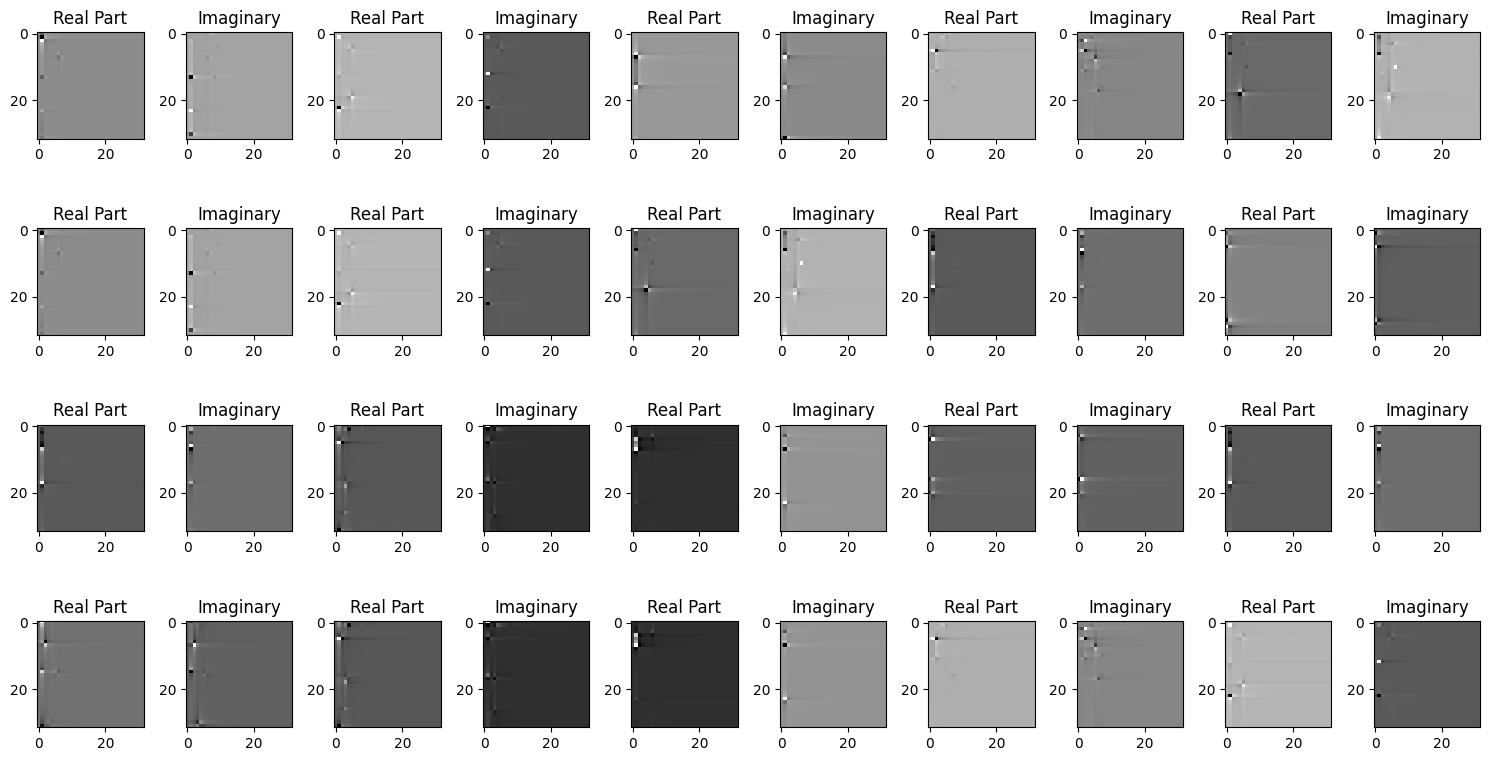

In [15]:
fig, axs = plt.subplots(4, 10, figsize=(15,8))
img_batch=x_train[200:220,:,:,:]

for i in range(0,10,2):
  for j in range(0,4):
    CSI_img = random.choice(img_batch)
    axs[j,i].imshow(np.array(CSI_img[0,:,:]), cmap='gist_gray')
    axs[j,i+1].imshow(np.array(CSI_img[1,:,:]), cmap='gist_gray')
    axs[j,i].set_title('Real Part')
    axs[j,i+1].set_title('Imaginary')
plt.tight_layout()

In [16]:
x_train = torch.tensor(x_train)
x_val = torch.tensor(x_val)
x_test = torch.tensor(x_test)
X_test = torch.tensor(X_test)

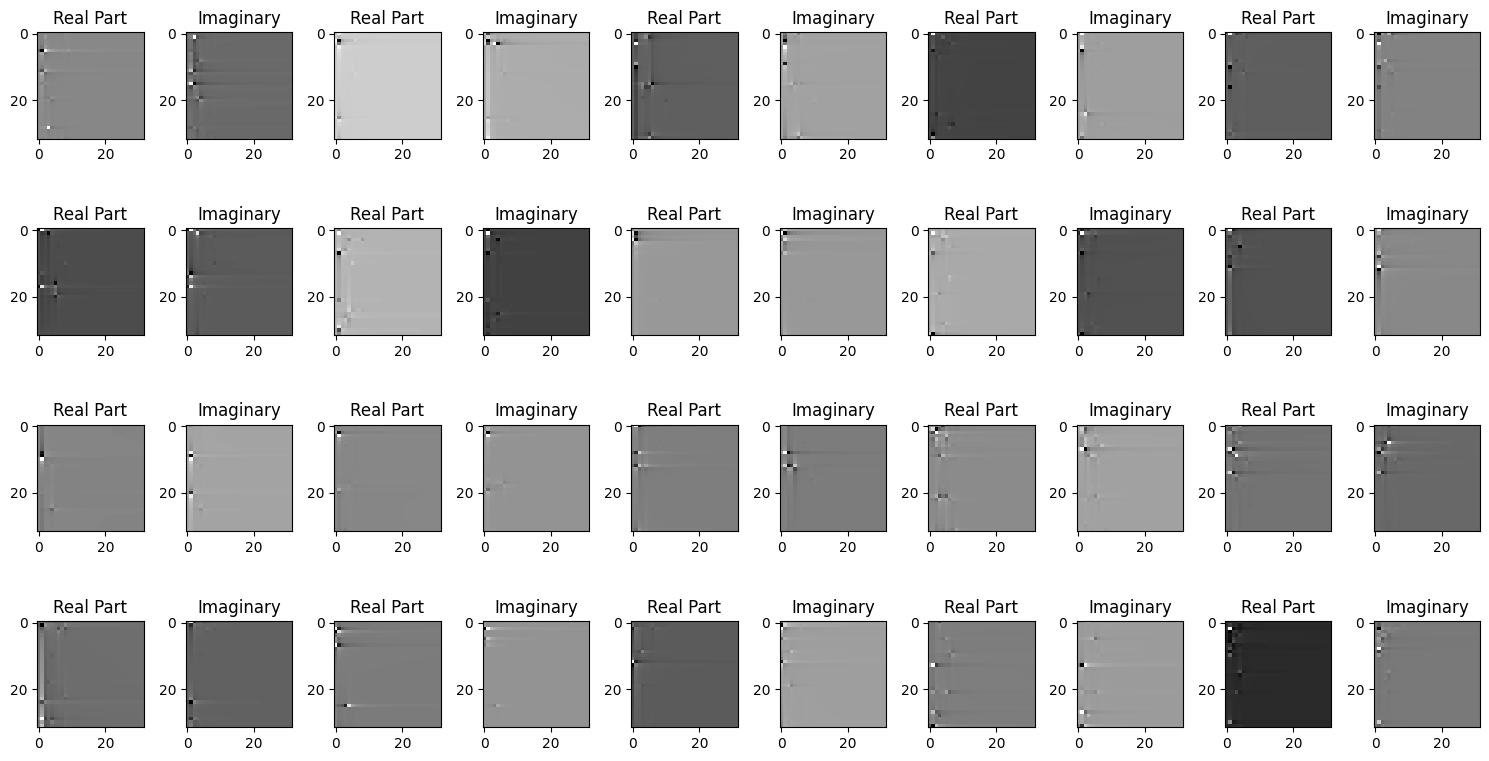

In [17]:
fig, axs = plt.subplots(4, 10, figsize=(15,8))
for i in range(0,10,2):
  for j in range(0,4):
    CSI_img = random.choice(x_train)
    axs[j,i].imshow(np.array(CSI_img[0,:,:]), cmap='gist_gray')
    axs[j,i+1].imshow(np.array(CSI_img[1,:,:]), cmap='gist_gray')
    axs[j,i].set_title('Real Part')
    axs[j,i+1].set_title('Imaginary')
plt.tight_layout()

In [18]:
# device
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)
x_train = x_train.to(device)
x_val = x_val.to(device)
x_test = x_test.to(device)
#noise=torch.randn((1,512)).to(device)


cuda


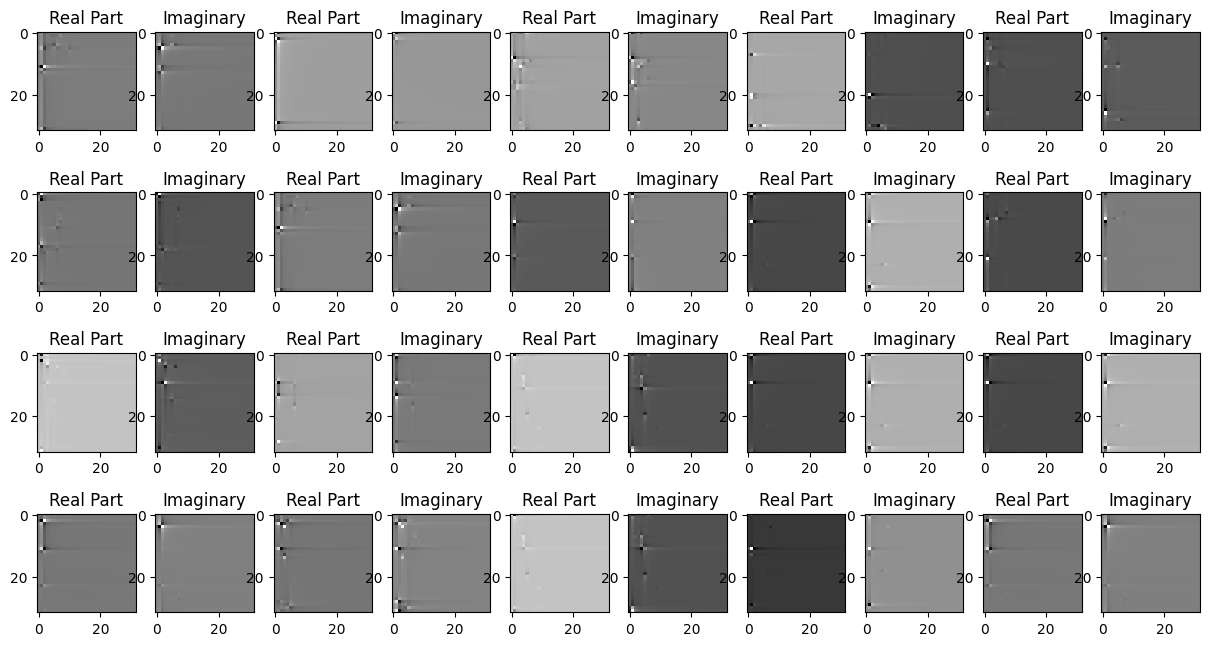

In [19]:
x_val_batch=x_val[0:20,:,:,:]
fig, axs = plt.subplots(4, 10, figsize=(15,8))
for i in range(0,10,2):
  for j in range(0,4):
    CSI_img = random.choice(x_val_batch.cpu())
    #print(CSI_img.shape)
    axs[j,i].imshow(np.array(CSI_img[0,:,:]), cmap='gist_gray')
    axs[j,i+1].imshow(np.array(CSI_img[1,:,:]), cmap='gist_gray')
    axs[j,i].set_title('Real Part')
    axs[j,i+1].set_title('Imaginary')
plt.show()

In [20]:
model = CLLWCsiNet().to(device)

torch.Size([5, 2, 32, 32])


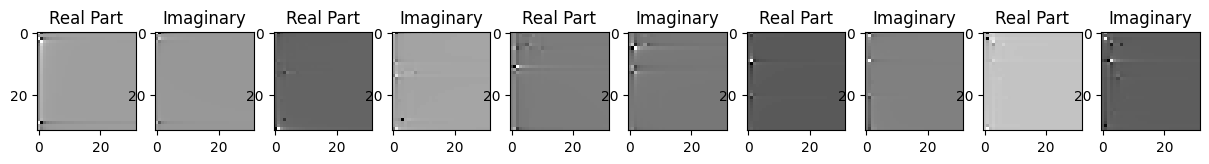

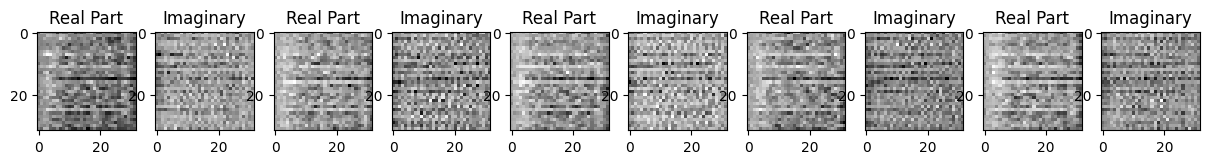

In [21]:
import itertools as it
with torch.no_grad():
  input=x_val[0:5,:,:,:]
  print(input.shape)
  model.eval()
  out = model(input)
  CSI_img_ = out.cpu()

  fig, axs = plt.subplots(1, 10, figsize=(15,8))
  for j, l in it.zip_longest(range(0, 5), range(1, 10,2)):
    in_img=input[j,0,:,:].cpu()
    axs[j*2].imshow(np.array(in_img.squeeze(0)), cmap='gist_gray')
    axs[j*2].set_title('Real Part')
    in_img=input[j,1,:,:].cpu()
    axs[l].imshow(np.array(in_img.squeeze(0)), cmap='gist_gray')
    axs[l].set_title('Imaginary')

  fig, axs = plt.subplots(1, 10, figsize=(15,8))
  for i, x in it.zip_longest(range(0, 5), range(1, 10,2)):

    #print(i)
    #CSI_img = random.choice(CSI_img_.cpu())
    img=CSI_img_[i,0,:,:]
    axs[i*2].imshow(np.array(img.squeeze(0)), cmap='gist_gray')
    axs[i*2].set_title('Real Part')
    img=CSI_img_[i,1,:,:]
    axs[x].imshow(np.array(img.squeeze(0)), cmap='gist_gray')
    axs[x].set_title('Imaginary')





  plt.show()

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-07)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

In [23]:
# loss function
criterion = nn.MSELoss()

n_epochs = 2500
batch_size = 200
total_batches = int(x_train_length/batch_size)

tStart = time.time()

train_loss_history = []
val_loss_history = []

In [24]:
encoded_dim = 512

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/_model_150_indoor_256_10x.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['lr_state_dict'])
start_epoch = checkpoint['epoch']

In [25]:

x_val=x_val[0:10000,:,:,:]

x_val_1=x_val = x_val.to(device)

In [ ]:
#epoch=550
with torch.autograd.set_detect_anomaly(True):
  for epoch in range(n_epochs):
      print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
      for i in range(total_batches):
          x_batch = x_train[i*batch_size:(i+1)*batch_size,]
          #print(i*batch_size,(i+1)*batch_size)

          # criterion = nn.MSELoss()
          # model.to(device)
          # optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-07)
          # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)


          model.train()

          out = model(x_batch)

          loss = criterion(out, x_batch)
          train_loss_history.append(loss.item())
          loss.backward()

          optimizer.step()
          optimizer.zero_grad()

      scheduler.step()

      # Validating
      with torch.no_grad():
          model.eval()

          out = model(x_val)
          loss = criterion(out, x_val)
          print("Loss: ",loss.item())
          val_loss_history.append(loss.item())



      with torch.no_grad():
        input=x_val[0:5,:,:,:]
        print(input.shape)
        model.eval()
        out = model(input)
        CSI_img_ = out.cpu()


        fig, axs = plt.subplots(1, 10, figsize=(15,8))
        for j, l in it.zip_longest(range(0, 5), range(1, 10,2)):
          in_img=input[j,0,:,:].cpu()
          axs[j*2].imshow(np.array(in_img.squeeze(0)), cmap='gist_gray')
          axs[j*2].set_title('Real Part')
          in_img=input[j,1,:,:].cpu()
          axs[l].imshow(np.array(in_img.squeeze(0)), cmap='gist_gray')
          axs[l].set_title('Imaginary')

        fig, axs = plt.subplots(1, 10, figsize=(15,8))
        for i, x in it.zip_longest(range(0, 5), range(1, 10,2)):

          #print(i)
          #CSI_img = random.choice(CSI_img_.cpu())
          img=CSI_img_[i,0,:,:]
          axs[i*2].imshow(np.array(img.squeeze(0)), cmap='gist_gray')
          axs[i*2].set_title('Real Part')
          img=CSI_img_[i,1,:,:]
          axs[x].imshow(np.array(img.squeeze(0)), cmap='gist_gray')
          axs[x].set_title('Imaginary')

        plt.show()


        if (epoch)%50==0:
          MODEL_PATH = Path("/kaggle/working/saved_model")
          MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                          exist_ok=True # if models directory already exists, don't error
          )


          # Create model save path
          MODEL_NAME = "CLLWCsiNet_model_{}_{}_{}_1x.pth".format(epoch,envir,encoded_dim)
          MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

          # Save the model state dict
          print(f"Saving model to: {MODEL_SAVE_PATH}")
          torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),
                      'lr_state_dict': scheduler.state_dict()}, # only saving the state_dict() only saves the learned parameters
                      f=MODEL_SAVE_PATH)

        #if epoch%50==0:
        with torch.no_grad():
            model.eval()
            x_hat = model(x_test)
            x_test = x_test.to(device)
            x_hat=x_hat.to(device)
            X_test = torch.reshape(X_test, (len(X_test), img_height, 125))
            x_test_real = torch.reshape(x_test[:, 0, :, :], (len(x_test), -1))
            x_test_imag = torch.reshape(x_test[:, 1, :, :], (len(x_test), -1))
            x_test_C = x_test_real - 0.5 + 1j * (x_test_imag - 0.5)
            x_hat_real = torch.reshape(x_hat[:, 0, :, :], (len(x_hat), -1))
            x_hat_imag = torch.reshape(x_hat[:, 1, :, :], (len(x_hat), -1))
            x_hat_C = x_hat_real - 0.5 + 1j * (x_hat_imag - 0.5)
            x_hat_F = torch.reshape(x_hat_C, (len(x_hat_C), img_height, img_width))
            X_hat = torch.fft.fft(torch.cat((x_hat_F, torch.zeros((len(x_hat_C), img_height, 257 - img_width)).to(device)), axis=2), axis=2)
            X_hat = X_hat[:, :, 0:125]

            n1 = torch.sqrt(torch.sum(torch.conj(X_test) * X_test, axis=1)).to(device)
            n2 = torch.sqrt(torch.sum(torch.conj(X_hat) * X_hat, axis=1)).to(device)
            aa = abs(torch.sum(torch.conj(X_test.to(device)) * X_hat, axis=1).to(device)).to(device)
            rho = torch.mean(aa / (n1 * n2), axis=1).to(device)
            X_hat = torch.reshape(X_hat, (len(X_hat), -1))
            X_test = torch.reshape(X_test, (len(X_test), -1))
            power = torch.sum(abs(x_test_C) ** 2, axis=1).to(device)
            power_d = torch.sum(abs(X_hat) ** 2, axis=1).to(device)
            mse = torch.sum(abs(x_test_C - x_hat_C) ** 2, axis=1).to(device)
            NMSE = 10 * math.log10(torch.mean(mse / power))
            Correlation = torch.mean(rho).item().real

            print("In " + envir + " environment")
            print("When dimension is", encoded_dim)
            print("NMSE is ", NMSE)
            print("Correlation is ", Correlation)

      #   import mysql.connector as mysql
      #   db = mysql.connect(
      #   host = "p3nlmysql165plsk.secureserver.net",
      #   user = "Hamide",
      #   passwd = "Vmkw788^6",
      #   database="Sale_find_customer"
      #  )


      #   mycursor = db.cursor()

      #   sql = "INSERT INTO paper_report	(Network_name, epocn_number,Val_loss,NMSE,Correlation,Status,operation_status	) VALUES (%s, %s,%s,%s,%s,%s,%s)"
      #   #val = ("ACRNET_10x_128_outdoor",'{}'.format(epoch+1),'{}'.format(loss.item()), '{}'.format(NMSE),'{}'.format(Correlation), "outdoor","live")
      #   val = ("َACRDNet_1x_512_indoor",'{}'.format(epoch),'{}'.format(loss.item()), '{}'.format(NMSE),'{}'.format(Correlation), "indoor","live")
      #   mycursor.execute(sql, val)

      #   db.commit()

      #   print(mycursor.rowcount, "record inserted.")









tEnd = time.time()
training_time = tEnd - tStart
print("It cost %f sec for training." % training_time)